In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


C:\Users\Ayushi thakur\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to C:\Users\Ayushi
[nltk_data]     thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ayushi
[nltk_data]     thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ayushi
[nltk_data]     thakur\AppData\Roaming\nltk_data...


True

In [3]:
data = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\ManuallyAnnotated_data.csv')
data = data[['tweet', 'Class']]  # assuming columns are named this way
data.dropna(inplace=True)


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned'] = data['tweet'].apply(clean_text)


In [5]:
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(data['cleaned'])


In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(data['cleaned'], show_progress_bar=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Ayushi thakur\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ayushi thakur\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

C:\Users\Ayushi thakur\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [7]:
nmf = NMF(n_components=4, random_state=42)
nmf_topics = nmf.fit_transform(X_tfidf)


In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_embed)


In [9]:
dbscan = DBSCAN(eps=1.0, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_embed)


In [11]:
print("KMeans Silhouette Score:", silhouette_score(X_embed, clusters_kmeans))
print("KMeans DB Score:", davies_bouldin_score(X_embed, clusters_kmeans))

# If labels available:
from sklearn.metrics import adjusted_rand_score
print("Adjusted Rand Index (KMeans vs true labels):", adjusted_rand_score(data['Class'], clusters_kmeans))


KMeans Silhouette Score: 0.1447496
KMeans DB Score: 2.596157736491379
Adjusted Rand Index (KMeans vs true labels): 0.48916847720780493


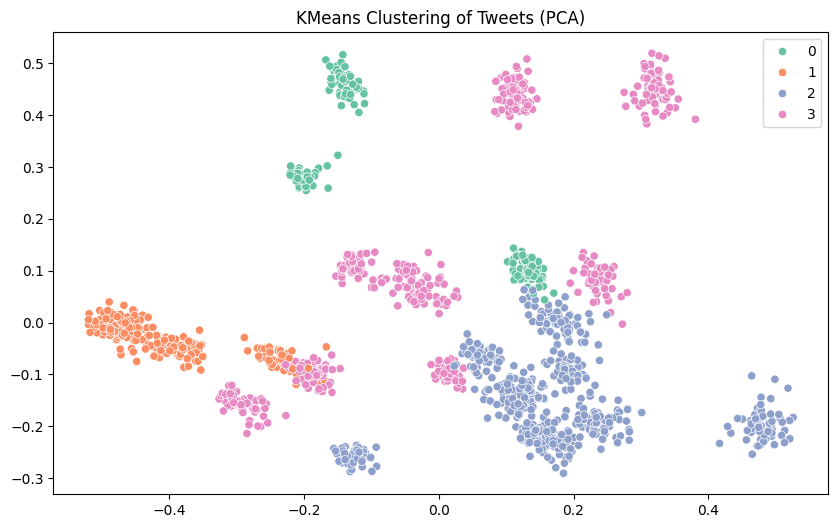

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(X_embed)
plt.figure(figsize=(10,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=clusters_kmeans, palette='Set2')
plt.title('KMeans Clustering of Tweets (PCA)')
plt.show()


In [14]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load Data
data = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\ManuallyAnnotated_data.csv')
data.dropna(subset=['tweet'], inplace=True)
tweets = data['tweet'].tolist()

# Clean Text (basic – optional if already cleaned)
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#|[^a-zA-Z\s]", "", text)
    return text

tweets_cleaned = [clean_text(t) for t in tweets]

# Sentence Embedding using SBERT
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # Fast & effective

# Create BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="english", verbose=True)

# Fit the model
topics, probs = topic_model.fit_transform(tweets_cleaned)

# Show top topics
topic_model.get_topic_info()


2025-04-10 22:04:48,391 - BERTopic - Embedding - Transforming documents to embeddings.


ImportError: cannot import name 'StaticEmbedding' from 'sentence_transformers.models' (C:\Users\Ayushi thakur\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\models\__init__.py)

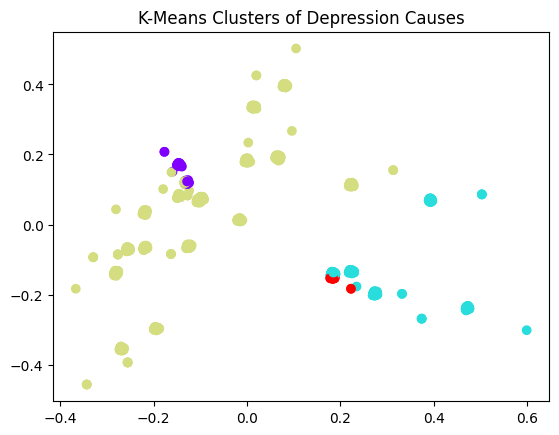

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your annotated dataset
df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\ManuallyAnnotated_data.csv')
  # this should have columns: 'tweet', 'label'

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['tweet'])

# Apply K-Means clustering (4 clusters for your 4 labels)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Assign clusters to data
df['cluster'] = kmeans.labels_

# (Optional) Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title("K-Means Clusters of Depression Causes")
plt.show()



Cluster 0 Example Tweets:
Depression caused by societal gender inequality...
Experiencing severe depression from gender bias...
Experiencing severe depression from gender bias...
Depression caused by societal gender inequality...
Experiencing severe depression from gender bias...

Cluster 1 Example Tweets:
Depressed and unable to find joy in anything. #216
Feeling deeply depressed from ongoing domestic ...
 Not sure why, but I've felt depressed lately. #72
Feeling deeply depressed from ongoing domestic ...
Not sure why, but I've felt depressed lately. #232

Cluster 2 Example Tweets:
Emotionally drained, can't pinpoint the cause. ...
Work stress has spiraled into deep depression. ...
Constant anxiety and stress have resulted in my...
Work stress has spiraled into deep depression. ...
Feeling persistently sad without clear reasons....

Cluster 3 Example Tweets:
Unequal pay makes me feel worthless and depress...
Unequal pay makes me feel worthless and depress...
Unequal pay makes me feel

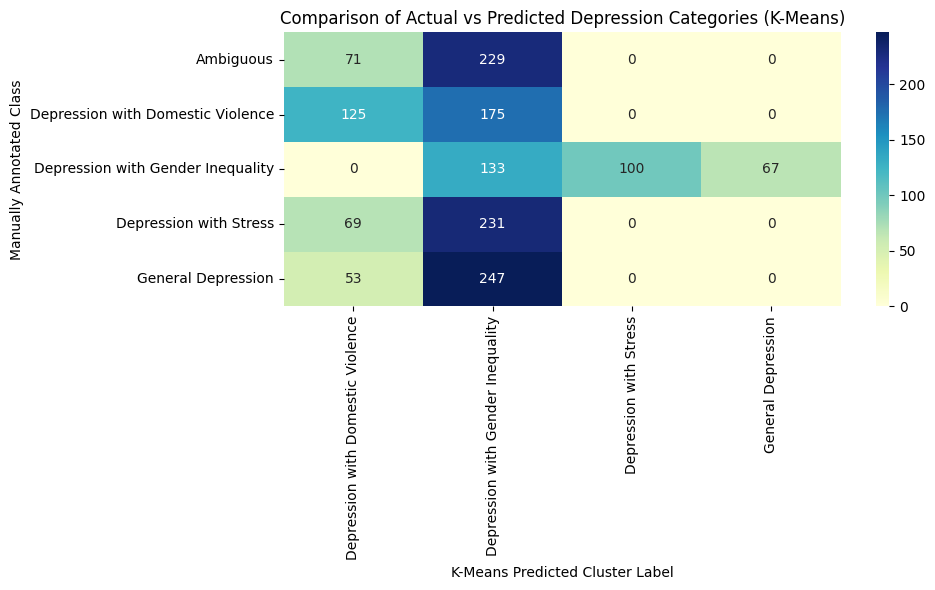

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
file_path = r'D:\unitec\MachineLearningCourse\Thesis_code\ManuallyAnnotated_data.csv'  # Adjust as needed
df = pd.read_csv(file_path)

# 2. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['tweet'])

# 3. Apply K-Means clustering (4 clusters for your 4 depression categories)
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 4. (Optional) View sample tweets per cluster to manually assign meaning
for i in range(4):
    print(f"\nCluster {i} Example Tweets:")
    print(df[df['cluster'] == i]['tweet'].head(5).to_string(index=False))

# 5. Map cluster IDs to labels (based on sample inspection)
cluster_label_map = {
    0: 'Depression with Stress',
    1: 'Depression with Domestic Violence',
    2: 'Depression with Gender Inequality',
    3: 'General Depression'
}
df['predicted_label'] = df['cluster'].map(cluster_label_map)

# 6. Plot confusion matrix (actual vs predicted)
comparison = pd.crosstab(df['Class'], df['predicted_label'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(10, 6))
sns.heatmap(comparison, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Comparison of Actual vs Predicted Depression Categories (K-Means)")
plt.ylabel("Manually Annotated Class")
plt.xlabel("K-Means Predicted Cluster Label")
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# Load new dataset (fixed file path)
new_tweets = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\classified_merged_Depression.csv')

# TF-IDF transform using the same vectorizer
X_new = vectorizer.transform(new_tweets['tweet'])

# Predict clusters
new_tweets['predicted_cluster'] = kmeans.predict(X_new)

# Map clusters to human-readable labels
cluster_label_map = {
    0: "Depression with Stress",
    1: "Depression with Domestic Violence",
    2: "Depression with Gender Inequality",
    3: "General Depression"
}
new_tweets['predicted_label'] = new_tweets['predicted_cluster'].map(cluster_label_map)

# Save results
new_tweets.to_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv', index=False)


C:\Users\Ayushi thakur\AppData\Local\Temp\ipykernel_6076\4200649284.py:6: DtypeWarning: Columns (0,2,13,14,15,19,20,21,22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  new_tweets = pd.read_csv(results_path)


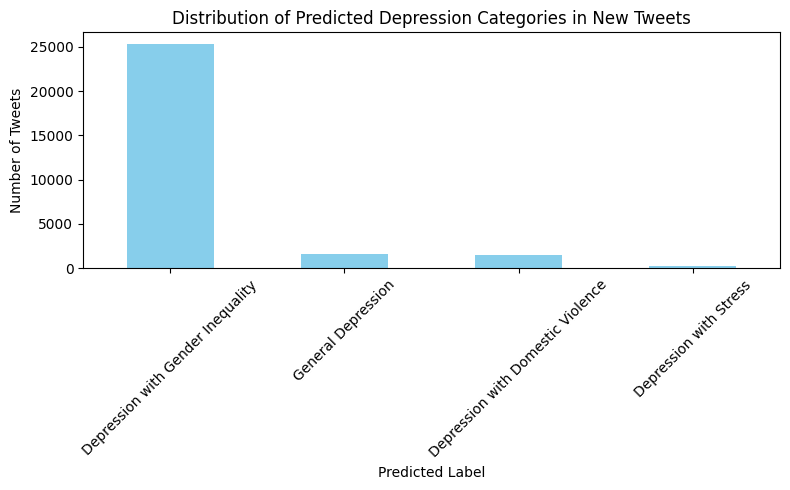

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the file from your local system
results_path = r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv'
new_tweets = pd.read_csv(results_path)

# Count predicted labels
label_counts = new_tweets['predicted_label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Predicted Depression Categories in New Tweets")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to C:\Users\Ayushi
[nltk_data]     thakur\AppData\Roaming\nltk_data...
C:\Users\Ayushi thakur\AppData\Local\Temp\ipykernel_6076\477012035.py:10: DtypeWarning: Columns (0,2,13,14,15,19,20,21,22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv')


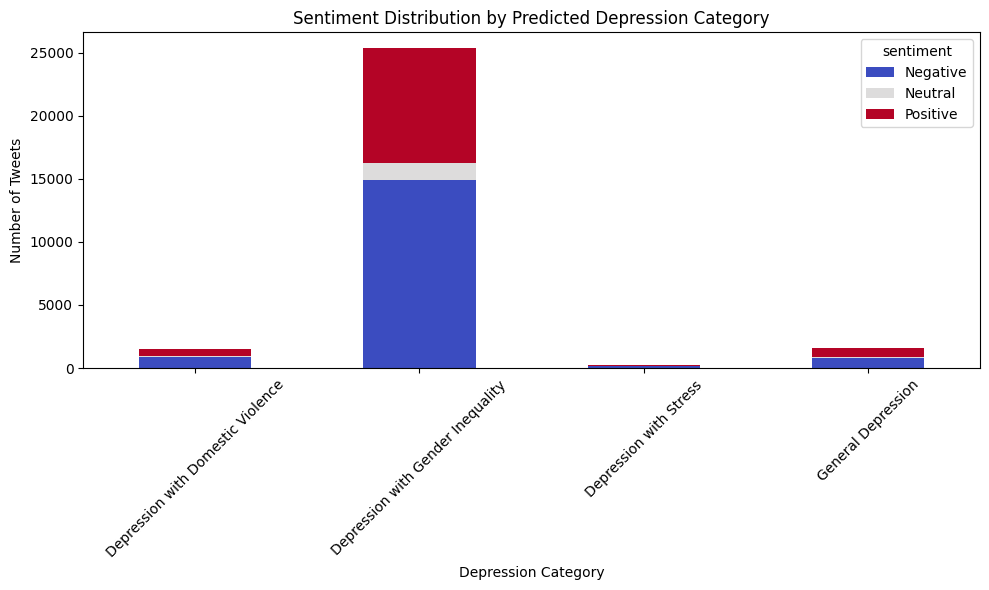

In [23]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Download the lexicon (only needs to be run once)
nltk.download('vader_lexicon')

# Load your result CSV
df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Classify sentiment
def classify_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['tweet'].apply(classify_sentiment)

# Visualize
sentiment_distribution = df.groupby('predicted_label')['sentiment'].value_counts().unstack().fillna(0)

sentiment_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Sentiment Distribution by Predicted Depression Category')
plt.xlabel('Depression Category')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to C:\Users\Ayushi
[nltk_data]     thakur\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Ayushi thakur\AppData\Local\Temp\ipykernel_6076\3629800460.py:11: DtypeWarning: Columns (0,2,13,14,15,19,20,21,22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv')


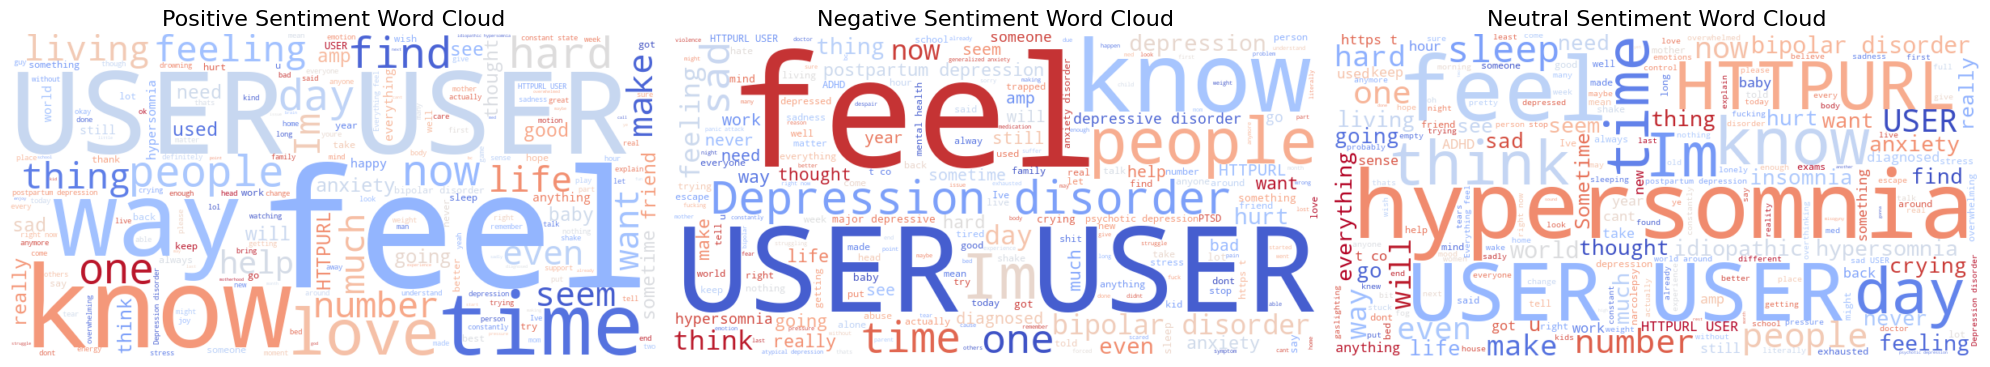

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import nltk

# Download lexicon (only needs to be run once)
nltk.download('vader_lexicon')

# Load data
df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\K-means_results.csv')

# VADER sentiment classification
sia = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['tweet'].apply(classify_sentiment)

# Word Cloud
sentiments = ['Positive', 'Negative', 'Neutral']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, sentiment in zip(axes, sentiments):
    text = ' '.join(df[df['sentiment'] == sentiment]['tweet'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm').generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{sentiment} Sentiment Word Cloud', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Labeled data (for training)
labeled_df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\ManuallyAnnotated_data.csv')  # Columns: 'text', 'label'
labeled_texts = labeled_df['tweet'].tolist()
labels = labeled_df['Class'].tolist()

# Unlabeled data (to predict)
unlabeled_df = pd.read_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\Tweet.csv')  # Only 'text' column
unlabeled_texts = unlabeled_df['tweet'].tolist()


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_labeled = vectorizer.fit_transform(labeled_texts)
X_unlabeled = vectorizer.transform(unlabeled_texts)  # Same vocab!

In [3]:
from sklearn.svm import SVC  # Or use LogisticRegression, RandomForest, etc.

# Train supervised model
clf = SVC(kernel='linear', probability=True)
clf.fit(X_labeled, labels)

SVC(kernel='linear', probability=True)

In [4]:
predicted_labels = clf.predict(X_unlabeled)
unlabeled_df['predicted_label'] = predicted_labels

In [6]:
from sklearn.cluster import KMeans

# Cluster unlabeled data (K=5)
kmeans = KMeans(n_clusters=5)
cluster_labels = kmeans.fit_predict(X_unlabeled)

# Assign most common classifier label per cluster
for cluster in range(5):
    cluster_tweets = unlabeled_df[cluster_labels == cluster]
    if len(cluster_tweets) > 0:
        preds = clf.predict(vectorizer.transform(cluster_tweets['tweet']))
        most_common_label = pd.Series(preds).mode()[0]
        unlabeled_df.loc[cluster_labels == cluster, 'final_label'] = most_common_label

In [7]:
unlabeled_df.to_csv(r'D:\unitec\MachineLearningCourse\Thesis_code\extended_labeled_tweets.csv', index=False)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_labeled, labels, test_size=0.2)
clf.fit(X_train, y_train)
print("Validation Accuracy:", clf.score(X_val, y_val))

Validation Accuracy: 1.0


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Load your synthetic diversified dataset
df = pd.read_csv(r"D:\unitec\MachineLearningCourse\Thesis_code\final_psychiatric_dataset_with_dv.csv")


# Features and labels
X = df['tweet']
y = df['Class']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert text data into TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")


Classification Report:
                                   precision    recall  f1-score   support

                        Ambiguous       0.49      0.54      0.51      1614
Depression with Domestic Violence       0.98      0.99      0.98      1310
Depression with Gender Inequality       0.44      0.09      0.15       773
           Depression with Stress       0.54      0.60      0.57      1268
               General Depression       0.56      0.63      0.59      2076

                         accuracy                           0.61      7041
                        macro avg       0.60      0.57      0.56      7041
                     weighted avg       0.60      0.61      0.59      7041

Accuracy: 0.61
Precision: 0.60
Recall: 0.61
F1-score: 0.59


In [8]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(SVC(), parameters, scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

best_svm = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Load your synthetic diversified dataset
df = pd.read_csv(r"D:\unitec\MachineLearningCourse\Thesis_code\final_psychiatric_dataset_with_dv.csv")


# Features and labels
X = df['tweet']
y = df['Class']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert text data into TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1_score:.2f}")
